# Multi-Object Optimization

This notebook allows the identification of paths that balance multiple objectives, e.g., distance, comfort, safety, for pedestrians and cyclists.

The graphs used are created using Neo4j through the code in the GitHub repository: [https://github.com/federicarollo/GRAFMOVE](https://github.com/federicarollo/GRAFMOVE).

Then, each graph was extracted as a collection of two CSV files, available in the **[data folder](https://github.com/federicarollo/ITADATA25/data)**, using the following Cypher queries:

- `MATCH (n) RETURN id(n) AS id, labels(n) AS labels, apoc.convert.toJson(properties(n)) AS properties` for nodes
- `MATCH (n)-[r]->(m) RETURN id(n) as source, id(m) as target, type(r) as type, apoc.convert.toJson(properties(r)) as properties` for edges

The graph structure follows the OpenStreetMap (OSM) structure:
- **Nodes** represent OSM-defined junctions or road shape points, mantaining the OSM identifier and the GPS coordinates as properties,
- **Edges** correspond to roads, with properties that describe their shape, length, type. The direction of the edge indicates the permitted travel direction.

<img src="../data/images/osm_structure_and_green.png" style="display: block; margin-left: auto; margin-right: auto;" alt="OSM structure" width="700"/>


<div>
  <br><br>
  <p style="float: left; width: 50%;">
The graph structure follows the OpenStreetMap (OSM) structure:<br>
- <b>Nodes</b> represent OSM-defined junctions or road shape points, maintaining the OSM identifier and the GPS coordinates as properties,<br>
- <b>Edges</b> correspond to roads, with properties that describe their shape, length, type. The direction of the edge indicates the permitted travel direction.<br>
  </p>
  <img src="../data/images/osm_structure_and_green.png" style="float: right; width: 40%; display: block; margin-left: auto; margin-right: auto;">
</div>


<div>
  <br><br>    
  <p style="float: left; width: 50%;">
    <b>FootNodes</b> represent nodes where pedestrian access is allowed, whereas <b>BikeNodes</b> correspond to nodes for cyclists.<br>ROUTE edges represent the roads.<br><br>The graph is enriched by the localization of the Point Of Interests (POIs) represented by the <b>POI</b> nodes, and linked to the corresponding elements in OSM (<b>OSMNode</b> or <b>OSMWay</b> if they are stored in OSM as node or way, respectively). The <b>Tag</b> nodes store the characteristics of the POIs (e.g., name, type such touristic attraction or parking).
  </p>
  <img src="../data/images/graph structure.png" style="display: block; margin-left: auto; margin-right: auto;" alt="Graph structure" style="float: right; width: 30%;">
</div>
<div style="clear: both;"></div>

## Configuration parameters

In [5]:
nodes_filename = "../data/graphs/Ferrara/ferrara_nodes.csv"
edges_filename = "../data/graphs/Ferrara/ferrara_edges.csv"

In [ ]:
OBJS_NOTIME = ["green_area_weight"]#, "foot_class"]
OBJS_TIME = ["pm25_per_meter"]#["crash_risk_density_norm"]
TIME_INTERVAL = 0 # one of the following values: {NIGHT: 0, MORNING: 1, AFTERNOON: 2, EVENING: 3}

N_OBJS = len(OBJS_NOTIME+OBJS_TIME)

N_CANDIDATE_PATHS = 1000

## Import libraries

In [8]:
import networkx as nx
import numpy as np
import pandas as pd
import json
# from itertools import combinations, islice, product, combinations_with_replacement

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.indicators.hv import HV
from pymoo.visualization.scatter import Scatter
from pymoo.termination.default import DefaultMultiObjectiveTermination

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [36]:
def double_unescape_json(s):
    unescaped = s.encode('utf-8').decode('unicode_escape')
    return json.loads(unescaped)

## Step 1 – Graph Import

In [10]:
nodes_df = pd.read_csv(nodes_filename)
edges_df = pd.read_csv(edges_filename)

In [9]:
nodes_df.shape

(55026, 3)

### Time-dependent properties vs time invariant properties

In [30]:
edges_df['properties'][233]

'{\\"foot_class\\":2,\\"distance\\":8.629131689296166,\\"green_area\\":0,\\"green_area_weight\\":8.629131689296166,\\"length\\":\\"8.619483996069556\\",\\"oneway\\":\\"False\\",\\"pm25\\":[17.964931417986364,35.213726853722704,22.390966066730627,20.3181468360084],\\"name\\":\\"Rampari di San Paolo\\",\\"geometry\\":\\"LINESTRING(11.6141052 44.8330706, 11.6141774 44.8330124)\\",\\"highway\\":\\"residential\\",\\"bike_class\\":2,\\"reversed\\":\\"True\\",\\"pm25_per_meter\\":[155.02175899497843,303.86388629167794,193.21459484038039,175.3279647303727]}'

In [40]:
double_unescape_json(edges_df['properties'][233])

{'foot_class': 2,
 'distance': 8.629131689296166,
 'green_area': 0,
 'green_area_weight': 8.629131689296166,
 'length': '8.619483996069556',
 'oneway': 'False',
 'pm25': [17.964931417986364,
  35.213726853722704,
  22.390966066730627,
  20.3181468360084],
 'name': 'Rampari di San Paolo',
 'geometry': 'LINESTRING(11.6141052 44.8330706, 11.6141774 44.8330124)',
 'highway': 'residential',
 'bike_class': 2,
 'reversed': 'True',
 'pm25_per_meter': [155.02175899497843,
  303.86388629167794,
  193.21459484038039,
  175.3279647303727]}

In [43]:
double_unescape_json(edges_df['properties'][233])['distance']

8.629131689296166

In [45]:
double_unescape_json(edges_df['properties'][233])['pm25']

[17.964931417986364, 35.213726853722704, 22.390966066730627, 20.3181468360084]

### Load the graph

In [11]:
%time

G = nx.DiGraph()

for _, row in nodes_df.iterrows():
    properties = double_unescape_json(row['properties'])
    G.add_node(row['id'], labels=row['labels'], **properties)

for _, row in edges_df.iterrows():
    properties = double_unescape_json(row['properties'])
    G.add_edge(row['source'], row['target'], label=row['type'], **properties)

CPU times: total: 34.2 s
Wall time: 36 s


In [12]:
print(f"Nodes: {len(G.nodes())}, Edges: {len(G.edges())}")

Nodes: 55026, Edges: 141480


### What are the properties of the FootNode instances?

In [15]:
node_properties = set()

for _, data in G.nodes(data=True):
    if 'FootNode' in data.get('labels', []):
        # Aggiungi tutte le chiavi tranne 'labels'
        node_properties.update(k for k in data.keys() if k != 'labels')

print(f"Properties of FootNode instances: {node_properties}")

Properties of FootNode instances: {'highway', 'street_count', 'id', 'componentId', 'bbox', 'latitude', 'railway', 'gtype', 'green_area', 'location', 'longitude', 'cyclist_allowed_grafmove', 'y', 'geometry', 'lat', 'lon', 'x', 'pedestrian_allowed_grafmove'}


### What are the properties of the ROUTE edge instances?

In [17]:
edge_property = set()

for u, v, data in G.edges(data=True):
    if data.get('label') == 'ROUTE':
        edge_property.update(k for k in data.keys() if k != 'labels')

print(f"Properties of ROUTE instances: {edge_property}")

Properties of ROUTE instances: {'highway', 'name', 'area', 'service', 'width', 'bridge', 'access', 'length', 'distance', 'junction', 'oneway', 'pm25', 'crs', 'created_date', 'green_area_weight', 'green_area', 'created_with', 'ref', 'tunnel', 'geometry', 'foot_class', 'pm25_per_meter', 'maxspeed', 'lanes', 'label', 'bike_class', 'reversed'}


### What are all the possible values of the *highway* property of ROUTE?

In [19]:
highway_values = set()

for _, _, data in G.edges(data=True):
    if data.get('label') == 'ROUTE' and 'highway' in data:
        highway_values.add(data['highway'])

print(highway_values)

{'pedestrian', 'tertiary_link', 'track', 'unclassified', 'secondary', 'trunk', 'service', 'bridleway', 'services', 'residential', 'motorway_link', 'trunk_link', 'primary_link', 'path', 'tertiary', 'motorway', 'steps', 'footway', 'living_street', 'primary', 'road', 'cycleway'}


### Road length values

In [20]:
route_distances = [
    data['distance']
    for u, v, data in G.edges(data=True)
    if data.get('type') == 'ROUTE' and 'distance' in data
]

In [ ]:
ADD VISUALIZATION

## Step 2 - Path generation

In [1405]:
def get_candidate_paths(G, source, target, num_paths=10):
    paths = []
    for obj in OBJS_NOTIME:
        paths.append(nx.shortest_path(G, source, target, weight=obj))
    for obj in OBJS_TIME:
        paths.append(nx.shortest_path(G, source, target, weight=obj[TIME_INTERVAL]))
    for _ in range(num_paths - N_OBJS):
        random_path = nx.shortest_path(G, source, target, weight=lambda u, v, d: torch.rand(1).item())
        paths.append(random_path)
        
    return paths

In [1406]:
%%time
# FERRARA
# paths = get_candidate_paths(G, source="1150817556", target="2093992765", num_paths=500)
# paths = get_candidate_paths(G, source="958004696", target="259040297", num_paths=N_CANDIDATE_PATHS)
paths = get_candidate_paths(G, source="2211349960", target="1836899403", num_paths=N_CANDIDATE_PATHS)

# MODENA
# paths = get_candidate_paths(G, source="10053840073", target="2041913868", num_paths=N_CANDIDATE_PATHS)
# paths = get_candidate_paths(G, source="250846426", target="256411970", num_paths=N_CANDIDATE_PATHS)
# paths = get_candidate_paths(G, source="250850846", target="2021402066", num_paths=N_CANDIDATE_PATHS)

CPU times: total: 39.9 s
Wall time: 41.1 s


In [1407]:
print(f"Number of paths: {len(paths)}")

Number of paths: 1000


In [1408]:
no_duplicates = []

for element in paths:
    if(element not in no_duplicates):
        no_duplicates.append(element)

In [1409]:
print(f"Number of non duplicated paths: {len(no_duplicates)}")

Number of non duplicated paths: 695


In [1410]:
# def evaluate_path(G, path):
#     distance = 0
#     green_area_lenght = 0
#     pm25_per_meter = 0
#     for i in range(len(path) - 1):
#         u, v = path[i], path[i+1]
#         distance += G.edges[u, v]["distance"]
#         if(G.edges[u, v]["green_area"]==100):
#             green_area_lenght += G.edges[u, v]["distance"]
#         pm25_per_meter += G.edges[u, v]["pm25_per_meter"] if "pm25_per_meter" in G.edges[u, v] else 0
#         
#     return distance, green_area_lenght, pm25_per_meter/distance
# 
# path_data = []
# for path in no_duplicates:
#     d, g, p = evaluate_path(G, path)
#     path_data.append({"path": path, "distance": d, "green_area_lenght": g, 'avg_pm25_per_meter': p})

In [1411]:
def evaluate_path(G, path):
    eval_objs = {}

    for obj in OBJS_NOTIME:
        eval_objs[obj] = 0
    for obj in OBJS_TIME:
        eval_objs[obj] = 0
            
    for i in range(len(path)-1):
        u, v = path[i], path[i+1]
        
        for obj in OBJS_NOTIME:
            eval_objs[obj] += G.edges[u, v][obj]
        for obj in OBJS_TIME:
            value = float(G.edges[u, v][obj][0])
            eval_objs[obj] += value
        
    return eval_objs

path_data = []
for path in no_duplicates:
    eval_objs = evaluate_path(G, path)
    eval_objs["path"] = path
    path_data.append(eval_objs)

In [1412]:
print(f"Number of evaluated paths: {len(path_data)}")

Number of evaluated paths: 695


In [ ]:
path_data

In [1413]:
count=0
for p in path_data:
    if(p["distance"]==p["green_area_weight"]):
        count+=1
print(count)

654


## Step 3 - Pareto Front identification

In [1414]:
class RoutingProblem(Problem):
    def __init__(self, path_data):
        self.path_data = path_data
        super().__init__(n_var=1, n_obj=N_OBJS, n_constr=0, xl=0, xu=len(path_data) - 1)

    def _evaluate(self, X, out, *args, **kwargs):
        objs = []
        for i in X:
            idx = int(i[0])
            objs.append([self.path_data[idx][obj] for obj in OBJS_NOTIME+OBJS_TIME])
        out["F"] = np.array(objs)

In [1415]:
# class RoutingProblem(Problem):
#     def __init__(self, path_data):
#         self.path_data = path_data
#         super().__init__(n_var=1, n_obj=3, n_constr=0, xl=0, xu=len(path_data) - 1)
# 
#     def _evaluate(self, X, out, *args, **kwargs):
#         objs = []
#         for i in X:
#             idx = int(i[0])
#             objs.append([self.path_data[idx]["distance"], self.path_data[idx]["green_area_weight"], self.path_data[idx]["pm25_per_meter"]])
#         out["F"] = np.array(objs)

In [1416]:
%%time

termination = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=0.0025,
    period=30,
    n_max_gen=1000,
    n_max_evals=100000
)

problem = RoutingProblem(path_data)
algorithm = NSGA2(pop_size=10000) #len(path_data))
res = minimize(problem, algorithm, verbose=True, termination=termination)

pareto_front = res.F
pareto_solutions = [path_data[int(idx)] for idx in res.X]

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |    10000 |    867 |             - |             -
     2 |    20000 |   1743 |  0.000000E+00 |             f
     3 |    30000 |   2752 |  0.000000E+00 |             f
     4 |    40000 |   3942 |  0.000000E+00 |             f
     5 |    50000 |   5353 |  0.000000E+00 |             f
     6 |    60000 |   6895 |  0.000000E+00 |             f
     7 |    70000 |   8782 |  0.000000E+00 |             f
     8 |    80000 |  10000 |  0.000000E+00 |             f
     9 |    90000 |  10000 |  0.000000E+00 |             f
    10 |   100000 |  10000 |  0.000000E+00 |             f
CPU times: total: 1min 34s
Wall time: 1min 37s


<timed exec>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


In [1417]:
print(f"Number of solutions in pareto front: {len(pareto_solutions)}")

Number of solutions in pareto front: 10000


In [1418]:
pareto_solutions

[{'distance': 4524.98982023919,
  'green_area_weight': 3799.7040678315193,
  'foot_class': 267,
  'pm25': 1852.4705426248463,
  'path': ['2211349960',
   '2211349953',
   '2211349974',
   '2211349883',
   '2211349888',
   '2211349897',
   '258611683',
   '2211285081',
   '258611722',
   '258611743',
   '258612442',
   '2489155110',
   '258701172',
   '258613814',
   '258613815',
   '258613832',
   '258613810',
   '258614007',
   '258613935',
   '258613888',
   '258613886',
   '258613934',
   '258613889',
   '258612104',
   '1258754589',
   '2218408520',
   '258613969',
   '258613973',
   '2218408599',
   '2393712255',
   '2218408563',
   '1235745270',
   '258701217',
   '1235745415',
   '2125104555',
   '2125104549',
   '2125104465',
   '2125104511',
   '2125104513',
   '2125104536',
   '6305807381',
   '4504823249',
   '2125104446',
   '2125104435',
   '2125104546',
   '2125104438',
   '2125104444',
   '2125104447',
   '2125104448',
   '2125104520',
   '2125104452',
   '2125104455',
 

In [1419]:
count=0
tot_path=""
for p_sol in pareto_solutions:
    path = "python utils/path_utils.py --neo4jURL neo4j://localhost:7687 --neo4juser neo4j --neo4jpwd modenapass --points \""
    for id in p_sol['path']:
        path+=id+" "
    path+="\" --map_filename maps/example_"+str(count)+".html; "
    # print(path)
    tot_path+=path
    count+=1

C:\Users\feder\AppData\Local\Temp\ipykernel_2704\3465053780.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x, y, z, cmap='viridis', marker='o')


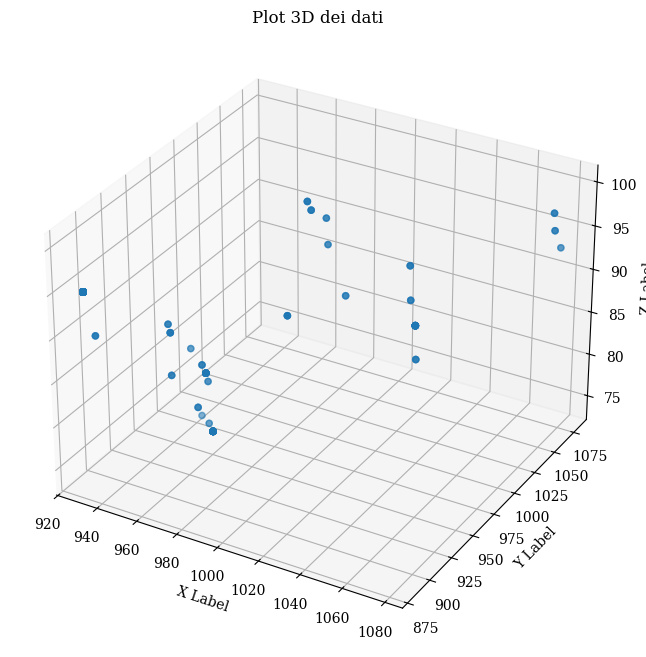

In [1032]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = pareto_front[:, 0]  # Prima colonna
y = pareto_front[:, 1]  # Seconda colonna
z = pareto_front[:, 2]  # Terza colonna

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(x, y, z, cmap='viridis', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.title('Plot 3D dei dati')
plt.show()

In [440]:
pareto_solutions[0]['distance']

3536.3926394978344

In [274]:
import pandas as pd

distances = []
green_areas = []
pm25_per_meter = []

for sol in path_data:
    distances.append(sol['distance'])
    green_areas.append(sol['green_area_weight'])
    #pm25_per_meter.append(sol['pm25_per_meter'])

dict_values = pd.DataFrame({'distances': distances, 'green_areas': green_areas})

In [1]:
plt.scatter([d["distance"] for d in path_data], [s["green_area_weight"] for s in path_data], color="blue")
plt.scatter([s["distance"] for s in pareto_solutions], [s["green_area_weight"] for s in pareto_solutions], color="red", label="Pareto Front")
plt.xlabel("distance")
plt.ylabel("green_area_weight")
plt.title("Pareto Front")
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'plt' is not defined

In [247]:
plt.scatter([d["distance"] for d in path_data], [s["pm25_per_meter"] for s in path_data], color="blue")
plt.scatter([s["distance"] for s in pareto_solutions], [s["pm25_per_meter"] for s in pareto_solutions], color="red", label="Pareto Front")
plt.xlabel("distance")
plt.ylabel("pm25_per_meter")
plt.title("Pareto Front")
plt.grid(True)
plt.legend()
plt.show()

14

In [ ]:
plt.scatter([d["pm25_per_meter"] for d in path_data], [s["green_area_weight"] for s in path_data], color="blue")
plt.scatter([s["pm25_per_meter"] for s in pareto_solutions], [s["green_area_weight"] for s in pareto_solutions], color="red", label="Pareto Front")
plt.xlabel("pm25_per_meter")
plt.ylabel("green_area_weight")
plt.title("Pareto Front")
plt.grid(True)
plt.legend()
plt.show()

In [1436]:
def normalize_objectives(F):
    F_min = F.min(axis=0)
    F_max = F.max(axis=0)
    return (F - F_min) / (F_max - F_min + 1e-9), F_min, F_max


def calculate_normalized_hypervolume(F, ref_point=None, verbose=True):
    F_norm, F_min, F_max = normalize_objectives(F)

    if ref_point is None:
        ref_point = np.ones(F.shape[1]) * 1.1

    hv = HV(ref_point=ref_point)
    hv_value = hv.do(F_norm)

    print(f"Normalized hypervolume: {hv_value:.6f}")
    print(f"Ref point: {ref_point}")

    return hv_value, F_norm


def plot_normalized_pareto(F_norm):

    plot = Scatter()
    plot.add(F_norm, facecolor="none", edgecolor="red")
    # plot.xlabel("distance")
    # plot.ylabel("green_area_weight")
    # plot.zlabel("pm25_per_meter")
    plt.title("Normalized Pareto Front")
    plt.grid(True)
    plot.show()

    if F_norm.shape[1] == 2:
        plt.scatter(F_norm[:, 0], F_norm[:, 1])
        plt.xlabel("Obiettivo 1 (normalizzato)")
        plt.ylabel("Obiettivo 2 (normalizzato)")
    elif F_norm.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(F_norm[:, 0], F_norm[:, 1], F_norm[:, 2])
        ax.set_xlabel("distance")
        ax.set_ylabel("green_area_weight")
        ax.set_zlabel("pm25_per_meter")
    else:
        print("Plot supportato solo per 2 o 3 obiettivi.")
        return
    plt.title("Normalized Pareto Front")
    plt.grid(True)
    plt.show()

Normalized hypervolume: 1.085414
Ref point: [1.1 1.1 1.1 1.1]
Plot supportato solo per 2 o 3 obiettivi.


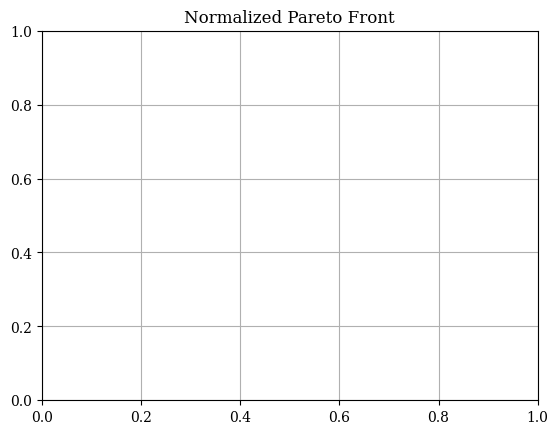

In [1438]:
hv_value, F_norm = calculate_normalized_hypervolume(res.F)
plot_normalized_pareto(F_norm)

In [1439]:
F_norm

array([[1.        , 0.57152901, 0.        , 0.07311871],
       [0.82079503, 0.        , 1.        , 1.        ],
       [0.        , 0.10477126, 0.36454849, 0.01402467],
       ...,
       [0.46774763, 0.57933774, 0.18060201, 0.02167165],
       [0.07240164, 0.17822838, 0.34113712, 0.        ],
       [1.        , 0.57152901, 0.        , 0.07311871]])

In [1384]:
OBJS_NOTIME

['distance', 'green_area_weight', 'foot_class']

In [1388]:


path = ""
for p in path_data[3]['path']:
    path+=p+" "
print(path)

2211349960 2211349953 2211349974 2211349883 2211349888 2211349897 258611683 2211285081 258611722 258611743 258612442 2489155110 258701172 258613871 2622581597 528874095 258701370 258701275 258701301 1235745292 258701362 4594837189 258701288 2269728324 2269728343 2269728356 2269728308 2269728286 6329766037 258611652 6329766036 2629832014 2632671701 259029339 2632672033 2632671652 258701440 258611649 258701551 2313670917 258701498 9896832647 258701105 258701047 2269697362 258613703 258613706 2421121066 2093958029 258611281 2093957930 2125104557 2093957964 2125104561 259029133 2334422783 1235745691 993600630 993600812 993600910 993600699 993600960 993600871 993601006 1235797230 748838649 986413679 748838652 2476375462 1235745272 1235745694 2476375477 1235745383 748838620 1235745815 1110231612 938521024 1235745634 1235745161 1235745588 938521372 938521342 938521209 938521112 938521237 938521174 9529990374 938521086 1378783965 1378783969 938521335 2103380522 938521132 752658270 1836899403 


## Step 4 - Optimal path selection and interactive exploration

### 4.1 Find the best solution based on user preferences

In [1440]:
OBJS_NOTIME

['distance', 'green_area_weight', 'foot_class']

In [1441]:
OBJS_TIME

['pm25']

In [1442]:
USER_PREF #=[0.25, 0.25, 0.25, 0.25]

[0.7, 0.1, 0.1, 0.1]

In [1448]:
weights = np.array(USER_PREF)
score = (F_norm * weights).sum(axis=1)
best_idx = score.argmin()

In [1450]:
best_idx

79

In [1452]:
pareto_solutions[best_idx]

{'distance': 3182.8131723422207,
 'green_area_weight': 3182.8131723422207,
 'foot_class': 359,
 'pm25': 1689.277467129342,
 'path': ['2211349960',
  '2211349953',
  '2211349974',
  '2211349883',
  '2211349888',
  '2211349897',
  '258611683',
  '2211285081',
  '258611722',
  '258611743',
  '258612442',
  '2489155110',
  '258701172',
  '258613871',
  '2622581597',
  '528874095',
  '258701370',
  '258701275',
  '258701301',
  '1235745292',
  '258701362',
  '4594837189',
  '258701288',
  '2269728324',
  '2269728343',
  '2269728356',
  '2269728308',
  '2269728286',
  '6329766037',
  '258611652',
  '6329766036',
  '2629832014',
  '2632671701',
  '259029339',
  '2632672033',
  '2632671652',
  '258701440',
  '258611649',
  '258701551',
  '2313670917',
  '258701498',
  '9896832647',
  '258701105',
  '258701047',
  '2269697362',
  '258613703',
  '258613706',
  '2421121066',
  '2093958029',
  '2093957949',
  '2093957930',
  '2125104557',
  '2093957964',
  '2125104561',
  '259029133',
  '233442278

In [1454]:
res.X[best_idx]

array([204.90012574])

In [1456]:
path = ""
for p in pareto_solutions[best_idx]['path']:
    path+=p+" "
print(path)
B=path

2211349960 2211349953 2211349974 2211349883 2211349888 2211349897 258611683 2211285081 258611722 258611743 258612442 2489155110 258701172 258613871 2622581597 528874095 258701370 258701275 258701301 1235745292 258701362 4594837189 258701288 2269728324 2269728343 2269728356 2269728308 2269728286 6329766037 258611652 6329766036 2629832014 2632671701 259029339 2632672033 2632671652 258701440 258611649 258701551 2313670917 258701498 9896832647 258701105 258701047 2269697362 258613703 258613706 2421121066 2093958029 2093957949 2093957930 2125104557 2093957964 2125104561 259029133 2334422783 1235745691 993600630 993600812 993600910 993600699 993600960 993600871 993601006 1235797230 748838649 986413679 748838652 2476375462 1235745272 1235745694 2476375477 1235745383 748838620 1235745815 10819481304 1235745214 1235745634 1235745161 1235745588 1235745422 9529990366 9529990367 9529990368 9529990369 9529990370 938521174 9529990374 938521086 1378783965 1378783969 938521335 2103380522 938521132 752

### 4.2 Find the solution with the optimal trade-off (points closest to the center of pareto front)

In [1458]:
from numpy.linalg import norm

distances = norm(F_norm, axis=1)
best_idx = distances.argmin()

In [1460]:
pareto_solutions[best_idx]

{'distance': 3195.2313118971715,
 'green_area_weight': 3195.2313118971715,
 'foot_class': 349,
 'pm25': 1724.9215596037322,
 'path': ['2211349960',
  '2211349953',
  '2211349974',
  '2211349883',
  '2211349888',
  '2211349897',
  '258611683',
  '2211285081',
  '258611722',
  '258611743',
  '258612442',
  '2489155110',
  '258701172',
  '258613871',
  '2622581597',
  '528874095',
  '258701370',
  '258701275',
  '258701301',
  '1235745292',
  '258701362',
  '4594837189',
  '258701288',
  '2269728324',
  '2269728343',
  '2269728356',
  '6329753927',
  '6329753928',
  '6329753929',
  '6329766037',
  '258611652',
  '6329766036',
  '2629832014',
  '2632671973',
  '2632671742',
  '259029339',
  '2632672033',
  '2632671652',
  '258701440',
  '258611649',
  '258701551',
  '2313670917',
  '258701498',
  '9896832647',
  '258701105',
  '258701047',
  '2269697362',
  '258613703',
  '258613706',
  '2421121066',
  '2093958029',
  '2093957949',
  '2093957930',
  '2125104557',
  '2093957964',
  '2125104

In [1462]:
path = ""
for p in pareto_solutions[best_idx]['path']:
    path+=p+" "
print(path)
C=path

2211349960 2211349953 2211349974 2211349883 2211349888 2211349897 258611683 2211285081 258611722 258611743 258612442 2489155110 258701172 258613871 2622581597 528874095 258701370 258701275 258701301 1235745292 258701362 4594837189 258701288 2269728324 2269728343 2269728356 6329753927 6329753928 6329753929 6329766037 258611652 6329766036 2629832014 2632671973 2632671742 259029339 2632672033 2632671652 258701440 258611649 258701551 2313670917 258701498 9896832647 258701105 258701047 2269697362 258613703 258613706 2421121066 2093958029 2093957949 2093957930 2125104557 2093957964 2125104561 259029133 2334422783 1235745691 993600630 993600812 993600910 993600699 993600960 993600871 993601006 1235797230 748838649 986413679 748838652 2476375462 1235745272 1235745694 2476375477 1235745383 748838620 1235745815 10819481304 1235745214 1235745634 1235745161 1235745588 1235745422 9529990366 9529990367 9529990368 9529990369 9529990370 938521174 9529990374 938521086 1378783965 1378783969 938521335 21

In [1161]:
A==C

False

### 4.3 Find the best solution based on constraints